<a href="https://colab.research.google.com/github/3778/COVID-19/blob/master/notebooks/%5Bissue_62%5D_Covid_Auto_Arima.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/3778/COVID-19.git

Cloning into 'COVID-19'...
remote: Enumerating objects: 158, done.
remote: Counting objects: 100% (158/158), done.
remote: Compressing objects: 100% (107/107), done.
remote: Total 669 (delta 79), reused 102 (delta 42), pack-reused 511
Receiving objects: 100% (669/669), 1.14 MiB | 4.21 MiB/s, done.
Resolving deltas: 100% (324/324), done.


In [2]:
!pip install pmdarima

     |████████████████████████████████| 1.5MB 4.6MB/s 


In [0]:
import os
os.chdir('COVID-19')

In [0]:
import pandas as pd
from pmdarima import auto_arima

In [0]:
from data.collectors import load_dump_covid_19_data, load_jh_data

In [6]:
load_dump_covid_19_data()
jhu = load_jh_data()

by_uf data exported to data/csv/covid_19/by_uf/by_uf.csv
by_city data exported to data/csv/covid_19/by_city/by_city.csv


# Simular como teria sido acompanhar o histórico que já temos fazendo previsões para os próximos `forecast_n_days`
(ex: Simulação do que teria acontecido se eu tivesse tentado prever de 7 em 7 dias os próximos 7 dias)


In [0]:
def simulate(data, forecast_n_days=7, n_history=None):
    lag = pd.DateOffset(days=forecast_n_days)
    one_day = pd.DateOffset(days=1)
    dmin, dmax = data.index.min(), data.index.max()
    date_range = (
        pd
        .date_range(
            start=dmin+lag,
            end=dmax-lag,
            freq=f'{forecast_n_days}D'
        )
    )
    look_back = pd.DateOffset(
        days=(dmax-dmin).days if n_history is None else n_history
    )
    forecasts = []
    for date in date_range:
        train = data.loc[date-look_back:date]
        test = data.loc[date+one_day:date+lag]
        model = (
            auto_arima(
                train,
                start_p=1,
                d=None,
                start_q=1,
                max_p=15,
                max_d=15,
                max_q=15,
                seasonal=False,
                suppress_warnings=True,
                maxiter=500,
                stepwise=False
            )
        )
        forecast = model.predict(test.shape[0])
        forecasts.append(
            pd.Series(forecast, index=test.index)
        )
    return (
        pd
        .concat(
            [
                data,
                (
                    pd
                    .concat(forecasts)
                    .rename('forecast')
                )
            ],
            axis=1
        )
    )

# Brasil

In [0]:
data = (
    pd
    .read_csv(
        'data/csv/covid_19/by_uf/by_uf.csv'
    )
    .query('date >= "2020-03-01"')
    .groupby('date')
    ['cases']
    .sum()
)
data.index = pd.to_datetime(data.index)

In [9]:
sim = simulate(data, forecast_n_days=3, n_history=None)

/usr/local/lib/python3.6/dist-packages/pmdarima/arima/_auto_solvers.py:386: ModelFitWarning: Unable to fit ARIMA for (1, 0, 2)x(0, 0, 0, 0); data is likely non-stationary. (if you do not want to see these warnings, run with error_action="ignore")
  ModelFitWarning)
/usr/local/lib/python3.6/dist-packages/pmdarima/arima/_auto_solvers.py:386: ModelFitWarning: Unable to fit ARIMA for (2, 0, 2)x(0, 0, 0, 0); data is likely non-stationary. (if you do not want to see these warnings, run with error_action="ignore")
  ModelFitWarning)
/usr/local/lib/python3.6/dist-packages/pmdarima/arima/_auto_solvers.py:386: ModelFitWarning: Unable to fit ARIMA for (1, 0, 3)x(0, 0, 0, 0); data is likely non-stationary. (if you do not want to see these warnings, run with error_action="ignore")
  ModelFitWarning)
/usr/local/lib/python3.6/dist-packages/pmdarima/arima/_auto_solvers.py:386: ModelFitWarning: Unable to fit ARIMA for (2, 0, 3)x(0, 0, 0, 0); data is likely non-stationary. (if you do not want to see the

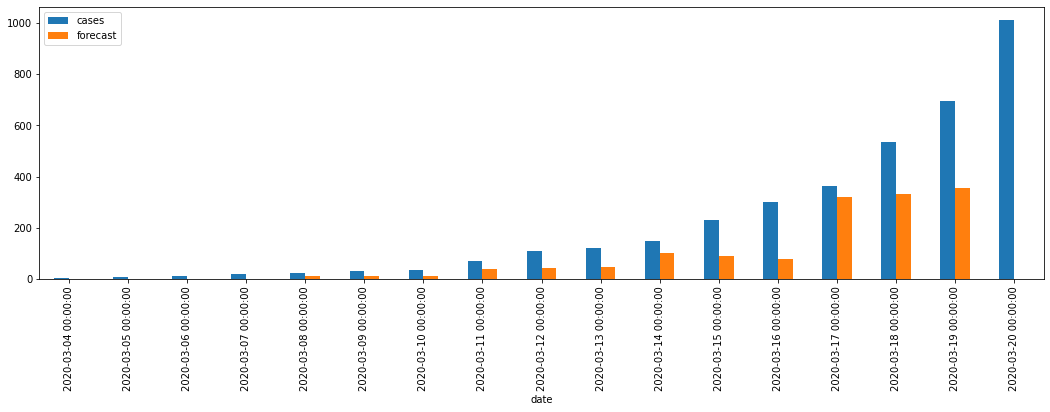

In [10]:
sim.plot.bar(figsize=(18, 5));

# Mundo

In [0]:
ser = 'China'
data = (
    jhu
    .set_index('country')
    .loc[ser]
    .reset_index(drop=True)
    .set_index('date')
    ['cases']
)
data.index = pd.to_datetime(data.index)

In [12]:
sim = simulate(data, forecast_n_days=3, n_history=None)

/usr/local/lib/python3.6/dist-packages/pmdarima/arima/_auto_solvers.py:386: ModelFitWarning: Unable to fit ARIMA for (1, 0, 2)x(0, 0, 0, 0); data is likely non-stationary. (if you do not want to see these warnings, run with error_action="ignore")
  ModelFitWarning)
/usr/local/lib/python3.6/dist-packages/pmdarima/arima/_auto_solvers.py:386: ModelFitWarning: Unable to fit ARIMA for (2, 0, 1)x(0, 0, 0, 0); data is likely non-stationary. (if you do not want to see these warnings, run with error_action="ignore")
  ModelFitWarning)
/usr/local/lib/python3.6/dist-packages/pmdarima/arima/_auto_solvers.py:386: ModelFitWarning: Unable to fit ARIMA for (2, 0, 2)x(0, 0, 0, 0); data is likely non-stationary. (if you do not want to see these warnings, run with error_action="ignore")
  ModelFitWarning)
/usr/local/lib/python3.6/dist-packages/pmdarima/arima/_auto_solvers.py:386: ModelFitWarning: Unable to fit ARIMA for (1, 0, 3)x(0, 0, 0, 0); data is likely non-stationary. (if you do not want to see the

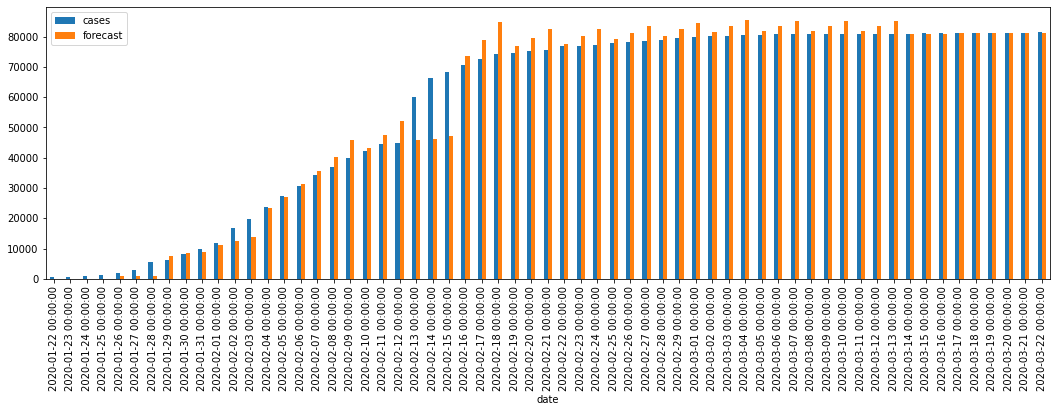

In [13]:
sim.plot.bar(figsize=(18, 5));